In [1]:
import time
import requests
import warnings
import importlib
import numpy as np
import pandas as pd
import seaborn as sns
from astropy.wcs import WCS
from astropy import units as u
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from skimage.measure import EllipseModel
from matplotlib.colors import ListedColormap
from astropy.io import fits
from skimage.measure import label as ConnectRegion
from matplotlib.patches import Ellipse, Rectangle
from scipy.optimize import curve_fit, minimize, fsolve
from scipy.interpolate import interp1d
from io import BytesIO
from astropy.coordinates import SkyCoord
from scipy.signal import convolve2d
from scipy.special import gamma, gammainc
from scipy.ndimage import gaussian_filter
from scipy.integrate import quad
from astropy.table import Table
import sympy as smp
from sympy.solvers import solve
from astropy.convolution import convolve, convolve_fft,  Gaussian2DKernel
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
warnings.filterwarnings('ignore')
import ztfidr
import galaxy_phot as glp

In [2]:
importlib.reload(glp)
sample = ztfidr.get_sample()
host_data = ztfidr.io.get_host_data()

conds1 = (sample.data['redshift'] > 0 ) & (sample.data['redshift'] < 0.2) 
conds2 = np.intersect1d(host_data.index, sample.data.index)
data = host_data[['host_ra', 'host_dec']].loc[conds2].dropna()[conds1]
targets = data.index

df10 = Table.read('fits_files/survey-bricks-dr10-south.fits.gz', format='fits')

In [3]:
def super_ellipse(phi, a_, b_, pa, n, polar=True):
    a, b = max(a_, b_), min(a_, b_)
    r = (np.abs(np.cos(phi-pa)/a)**n + np.abs(np.sin(phi-pa)/b)**n ) **(-1/n)
    if polar:
        return r
    else:
        x = r*np.cos(phi)
        y = r*np.sin(phi)
        return x, y

In [2]:
a, b, pa, n, theta, r_p = smp.symbols('a, b, phi, n, theta, r_p', positive=True, real=True)
d_a, d_b, d_pa, d_n = smp.symbols('Δa, Δb, Δ\phi, Δn', positive=True, real=True)
r = (smp.Abs(smp.cos(theta-pa)/a)**n + smp.Abs(smp.sin(theta-pa)/b)**n ) **(-1/n)
r

((Abs(cos(phi - theta))/a)**n + (Abs(sin(phi - theta))/b)**n)**(-1/n)

In [3]:
out = smp.sqrt((r.diff(a)*d_a)**2 + (r.diff(b)*d_b)**2 + (r.diff(pa)*d_pa)**2 + (r.diff(n)*d_n)**2)
d_r = out.subs(r, r_p).subs(r**(-n), r_p**(-n))
d_r

sqrt(r_p**2*Δn**2*(-r_p**n*((Abs(cos(phi - theta))/a)**n*log(Abs(cos(phi - theta))/a) + (Abs(sin(phi - theta))/b)**n*log(Abs(sin(phi - theta))/b))/n + log(r_p**(-n))/n**2)**2 + r_p**2*r_p**(2*n)*Δ\phi**2*(-n*(Abs(cos(phi - theta))/a)**n*sin(phi - theta)*sign(cos(phi - theta))/Abs(cos(phi - theta)) + n*(Abs(sin(phi - theta))/b)**n*cos(phi - theta)*sign(sin(phi - theta))/Abs(sin(phi - theta)))**2/n**2 + r_p**2*r_p**(2*n)*Δb**2*(Abs(sin(phi - theta))/b)**(2*n)/b**2 + r_p**2*r_p**(2*n)*Δa**2*(Abs(cos(phi - theta))/a)**(2*n)/a**2)

In [38]:
bn, Re, Ie, sigma,r, n, alpha, beta = smp.symbols('b_n, R_e, I_e, sigma, r, n, alpha, beta', real=True, positive=True)
x, k = smp.symbols('x, k', real=True)
g = smp.exp(-(x)**2)
m = (1 + ((x)/alpha)**2)**(-beta)
I = smp.exp(-x**n)
smp.integrate(g, (x, 0, smp.oo))

sqrt(pi)/2

In [40]:
h = I.diff(x)
smp.integrate(smp.erf(x)*h, (x, 0, smp.oo))

-n*Integral(x**n*exp(-x**n)*erf(x)/x, (x, 0, oo))

In [66]:
I.diff(x).simplify().diff(x).simplify()

n*x**(n - 2)*(n*x**n - n + 1)*exp(-x**n)

In [80]:
smp.integrate(x**(n-1)*smp.erf(x), x).simplify()

(pi*x**n*erf(x) - sqrt(pi)*lowergamma(n/2 + 1/2, x**2))/(pi*n)

In [126]:
smp.lowergamma(n/2+smp.Rational(1,2), x**2).diff(x)

2*x*exp(-x**2)*Abs(x)**(n - 1)

In [118]:
smp.integrate(x**(2*n-1)*smp.exp(-x**n)*smp.erf(x), (x, 0, smp.oo))

Integral(x**(2*n - 1)*exp(-x**n)*erf(x), (x, 0, oo))

In [178]:
smp.integrate(x**(-1)*smp.erf(x), x)

2*x*hyper((1/2, 1/2), (3/2, 3/2), -x**2)/sqrt(pi)

In [134]:
smp.erf(x).diff()

2*exp(-x**2)/sqrt(pi)

In [157]:
smp.integrate(x**(3*n-1)*smp.exp(-x**n), x).simplify()

-(x**(2*n) + 2*x**n + 2)*exp(-x**n)/n

In [141]:
smp.integrate(x**n*smp.exp(-x**n)*smp.exp(-x**2), (x, 0, smp.oo))

Integral(x**n*exp(-x**2)*exp(-x**n), (x, 0, oo))

In [149]:
exps = smp.lowergamma(n/2 + smp.Rational(1,2), x**2) - 2/n*x*smp.exp(-x**2)
exps

lowergamma(n/2 + 1/2, x**2) - 2*x*exp(-x**2)/n

In [156]:
exps.subs(n, 3).subs(x, 1)

1 - 8*exp(-1)/3

In [104]:
from scipy.special import erf, gamma

In [46]:
def get_b(n):
    def func(b, n): return 1 - 2*gammainc(2*n[0], b)
    return fsolve(func, 1.9992*n - 0.3271, args=[n])

def bulge(r):
    Ie, Re, n = 1, 5, 2
    b = 1.9992*n - 0.3271
    return Ie * np.exp(-b*((np.abs(r)/Re)**(1/n)-1))

def psf(r):
    sigma = 1.7/(2*np.sqrt(2*np.log(2)))
    return 1/(sigma*np.sqrt(2*np.pi))*np.exp(-(1/2)*(r/sigma)**2)

In [47]:
# def get_b(n):
#     def func(b, n): return 1 - 2*gammainc(2*n[0], b)
#     return fsolve(func, 1.9992*n - 0.3271, args=[n])

# n_r = np.linspace(0.1, 8, 100)
# plt.plot(n_r, np.vectorize(get_b)(n_r), 'b-')
# plt.plot(n_r,  1.9992*n_r - 0.3271, 'r--')
# np.mean(np.vectorize(get_b)(n_r) - (1.9992*n_r - 0.3271))

In [150]:
def psf_convolve(r):
    def integrand(x):
        return bulge(x)*psf(r-x)
    integral = quad(integrand, -np.inf, np.inf)
    if integral[0] < integral[1]:
        return bulge(r)
    else:
        return integral[0]

In [181]:
r_r = np.linspace(-50, 50, 90000)
b_r = bulge(r_r)
g_r = psf(r_r)
res1 = convolve_fft(b_r, g_r)

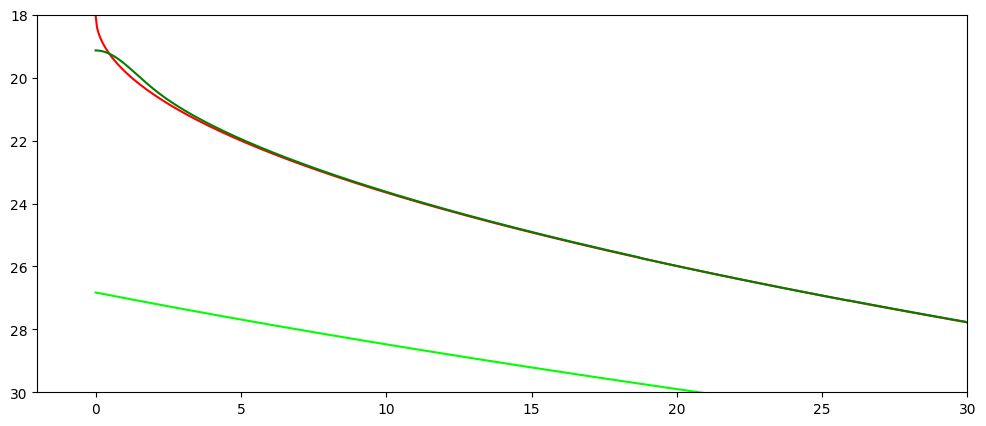

In [182]:
r_r = np.linspace(-50, 50, 1000)
b_r = bulge(r_r)
g_r = psf(r_r)
convolve_fft(b_r, g_r)
res = np.vectorize(psf_convolve)(r_r)

fig, ax = plt.subplots(figsize=(12, 5), dpi=100)
ax.plot(r_r, -2.5*np.log10(10**(-0.4*22)*b_r), 'r-')
ax.plot(r_r,-2.5*np.log10(10**(-0.4*22)*res), 'g-')
ax.plot(r_r, -2.5*np.log10(10**(-0.4*22)*convolve_fft(b_r, g_r)), 'g-', c='lime')
ax.set_ylim([18, 30])
ax.set_xlim([-2, 30])
ax.invert_yaxis()



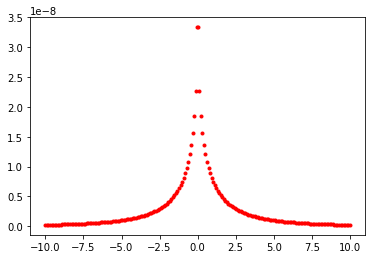

In [53]:
plt.plot(np.concatenate([-r_r, r_r]), bulge_e, 'r.')

$\left| \frac{x}{a} \right|^n + \left| \frac{y}{b} \right|^n = 1$

$x(t) = a|\cos t|^\frac{2}{n} \cdot sgn(\cos t)$

$y(t) = b|\sin t|^\frac{2}{n} \cdot sgn(\sin t)$

$\tan t = \left(\frac{a}{b}\right)^\frac{n}{2} |\tan \theta| ^ \frac{n}{2} \cdot sgn( \tan \theta)$

In [3]:
# x, y, a,b, n = smp.symbols('x, y, a,b, n', real=True)
# eqn = a/b*smp.tan(x) - smp.Abs(y)**(2/n)*smp.sign(y)
# sout = solve(eqn, y)
# sout[0].args[0][0]

(-30.0, 30.0)

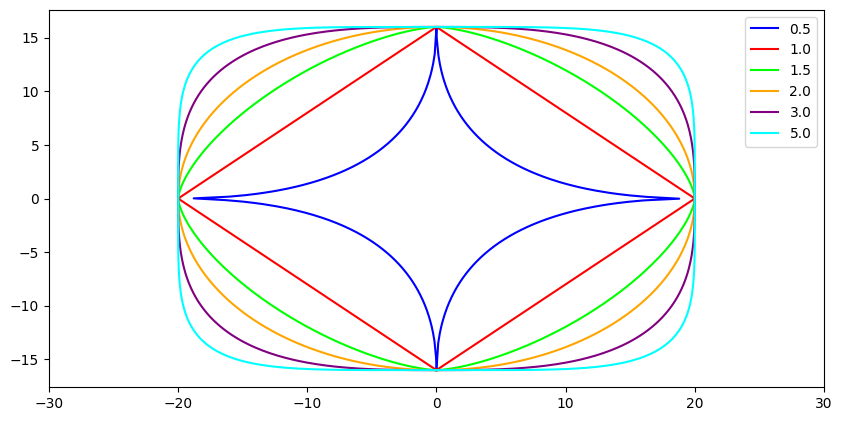

In [4]:
a = np.linspace(10, 20, 6)
b = np.linspace(8, 16, 6)
n = [0.5, 1, 1.5, 2, 3, 5]
colors = ['blue', 'red', 'lime', 'orange', 'purple', 'cyan']

fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
for i in range(6):
    glp.galaxy_decomp.patch_super_ellipse(self=glp.galaxy_decomp, pars=(20, 16, 0, n[i]), 
    center=(0, 0), ax=ax, color=colors[i], label=f'{n[i]:.1f}')
ax.legend()
ax.set_xlim([-30, 30])

In [5]:
sn_name = targets[622] # 2321, 622
gd = glp.galaxy_decomp(sn_name, verbose=True, mask=False, band='g', size='z', source='save', catalog='ztf')

ZTF18acatuts 336.49589303059406 3.4600505268453903 0.03683002 z_snid
legacy 328 0.262


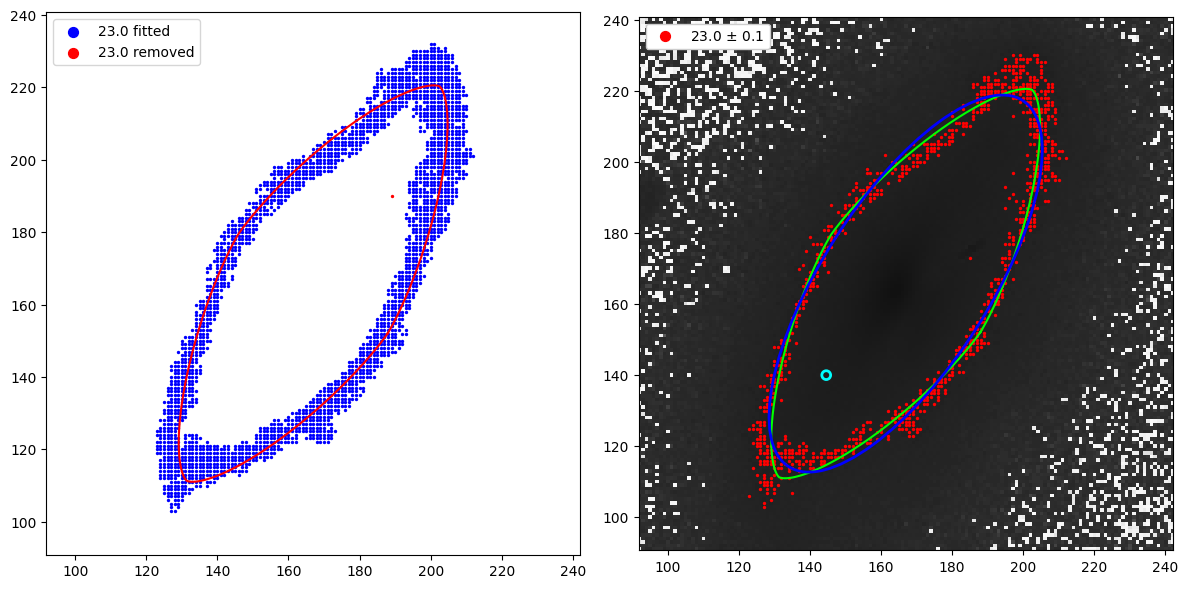

In [6]:
iso=23
gd.contour_fit(iso, window=0.3, mask=True)
ax1, ax2 = gd.plot_fit([iso], width=0.1, apply_mask=True, zoom=True)

ell = EllipseModel()
ell.estimate(gd.contours[23][1][1])
xc, yc, a, b, theta = ell.params

ell_patch = Ellipse((xc, yc), 2*a, 2*b, np.rad2deg(theta), edgecolor='blue', facecolor='none', zorder=10, lw=2)
ax2.add_patch(ell_patch)

In [7]:
ra, dec = gd.gobj.gal['host']
ra_, dec_ = df10[['ra', 'dec']].values()
near_bricks = np.argpartition(np.sqrt((ra - ra_)**2 + (dec - dec_)**2), [0])[[0]]

def plot_brick(i, ax, wcs):
    print(df10[i][['brickname', 'psfdepth_g']])
    data = df10[['ra1', 'ra2', 'dec1', 'dec2']].to_pandas()
    ra1, ra2, dec1, dec2 = data.iloc[i]
    c1 = SkyCoord(ra=ra1*u.degree, dec=dec1*u.degree, frame='icrs')
    c2 = SkyCoord(ra=ra2*u.degree, dec=dec2*u.degree, frame='icrs')
    sn_px1 = np.array(wcs.world_to_pixel(c1))
    sn_px2 = np.array(wcs.world_to_pixel(c2))
    print(sn_px1, sn_px2)
    rect_patch = Rectangle(sn_px1, width=sn_px2[0]-sn_px1[0], height=sn_px2[1]-sn_px1[1], edgecolor='red', facecolor='None', lw=1, zorder=10)
    ax.add_patch(rect_patch)

ZTF18acbblui 318.28455827 -20.71097102 0.04741 z_override
legacy 253 0.262
brickname psfdepth_g
--------- ----------
 3182m207  24.417034
[ 2866.85102199 -2127.77181917] [-564.68739748 1307.3551216 ]


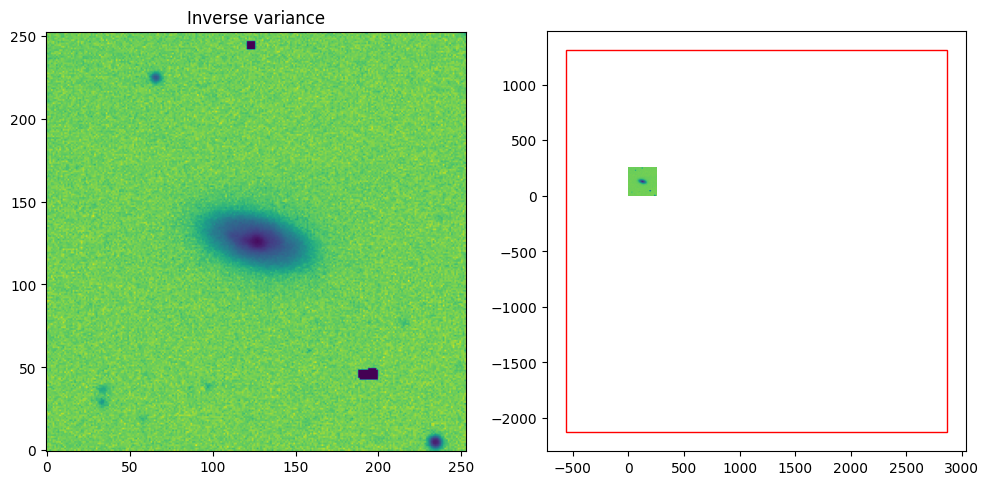

In [8]:
sn_name = targets[625]
gd2 = glp.galaxy_decomp(sn_name, verbose=True, mask=False, band='g', size='z', source='query', catalog='ztf')
fig, (ax1, ax2) = plt.subplots(figsize=(10,5), ncols=2, dpi=100)
ax1.imshow(gd2.invvar, origin='lower')
ax2.imshow(gd2.invvar, origin='lower')
ax1.set_title('Inverse variance')

ra, dec = gd2.gobj.gal['host']
near_bricks2 = np.argpartition(np.sqrt((ra - ra_)**2 + (dec - dec_)**2), [0])[[0]]
plot_brick(int(near_bricks2.value), ax2, gd2.gobj.cutout['wcs'])

ax2.autoscale()
plt.tight_layout()

ZTF18acbudzh 9.83387229105434 -10.482084930854334 0.03634158 z_gal
legacy 333 0.262
brickname psfdepth_g
--------- ----------
 0097m105  24.809185
[ 2684.80716262 -1797.41012182] [-745.19407906 1637.71770266]


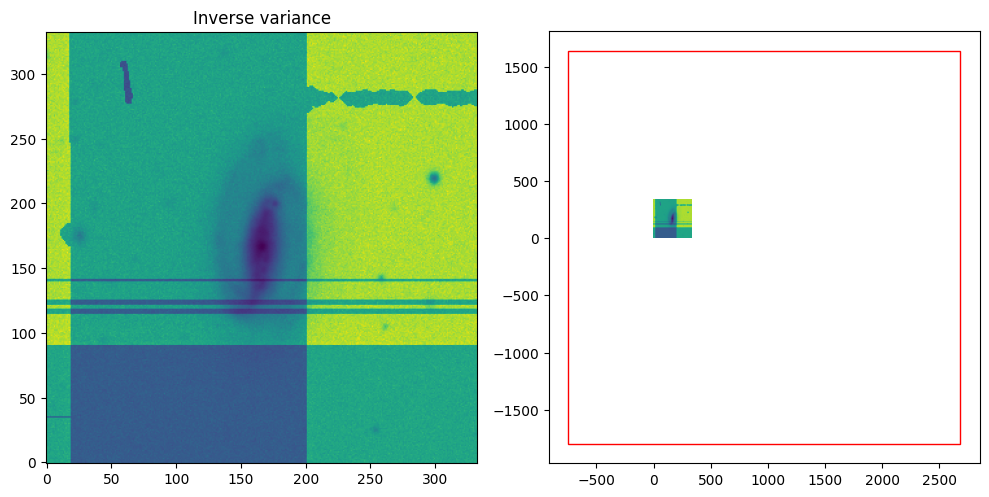

In [9]:
sn_name = targets[626]
gd2 = glp.galaxy_decomp(sn_name, verbose=True, mask=False, band='g', size='z', source='query', catalog='ztf')
fig, (ax1, ax2) = plt.subplots(figsize=(10,5), ncols=2, dpi=100)
ax1.imshow(gd2.invvar, origin='lower')
ax2.imshow(gd2.invvar, origin='lower')
ax1.set_title('Inverse variance')

ra, dec = gd2.gobj.gal['host']
near_bricks2 = np.argpartition(np.sqrt((ra - ra_)**2 + (dec - dec_)**2), [0])[[0]]
plot_brick(int(near_bricks2.value), ax2, gd2.gobj.cutout['wcs'])

ax2.autoscale()
plt.tight_layout()

brickname psfdepth_g
--------- ----------
 3365p035  24.778942
[  556.46981195 -1004.94956273] [-2877.01165961  2430.17852772]


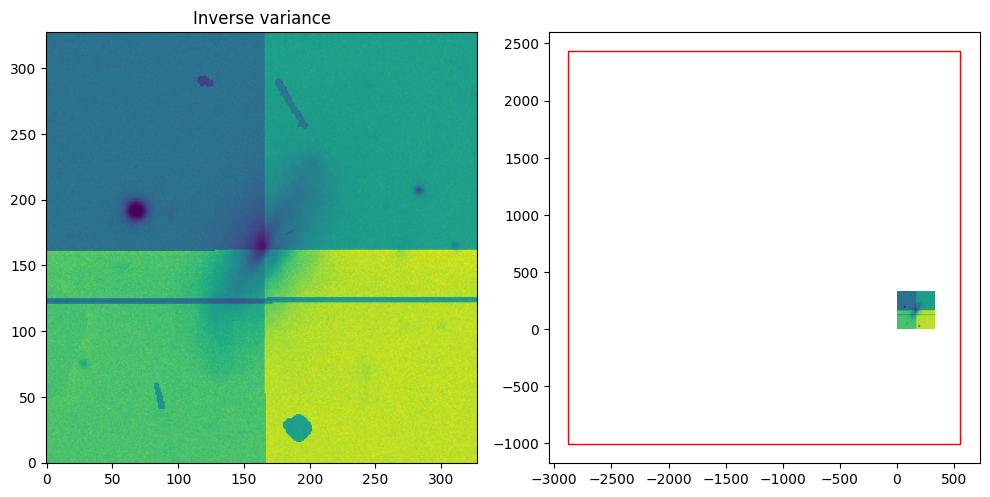

In [10]:
fig, (ax1, ax2) = plt.subplots(figsize=(10,5), ncols=2, dpi=100)
ax1.imshow(gd.invvar, origin='lower')
ax2.imshow(gd.invvar, origin='lower')
ax1.set_title('Inverse variance')

plot_brick(int(near_bricks.value), ax2, gd.gobj.cutout['wcs'])

ax2.autoscale()
plt.tight_layout()

In [11]:
mag_s = gd.image
mag = gd.gobj.cutout['mag_raw']
flux = gd.gobj.cutout['flux']

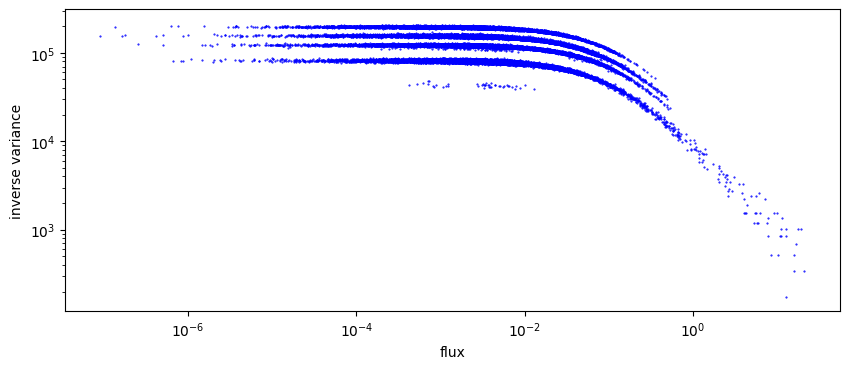

In [12]:
fig, ax = plt.subplots(figsize=(10,4), dpi=100)
yerr = gd.invvar.flatten()
ax.plot(flux.flatten(), yerr, 'b.', ms=1)
ax.set_xlabel('flux')
ax.set_ylabel('inverse variance')
ax.set_yscale('log')
ax.set_xscale('log')

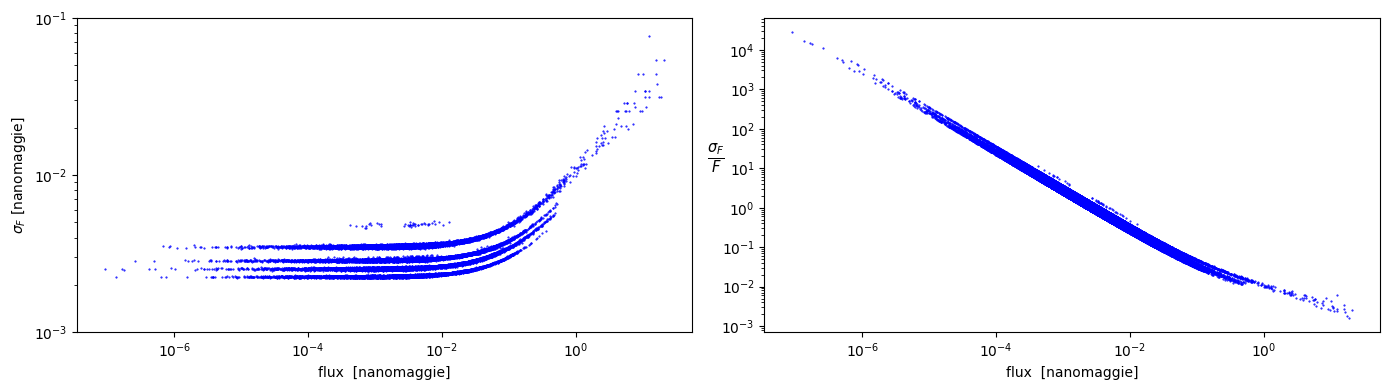

In [13]:
fig, (ax1, ax2) = plt.subplots(figsize=(14,4), dpi=100, ncols=2)
yerr = np.sqrt(1/gd.invvar.flatten())

ax1.plot(flux.flatten(), yerr, 'b.', ms=1)
ax1.set_xlabel('flux  [nanomaggie]')
ax1.set_ylabel('$\sigma_F$ [nanomaggie]')
ax1.set_ylim([0.001, 0.1])
ax1.set_yscale('log')
ax1.set_xscale('log')

ax2.plot(flux.flatten(), yerr/flux.flatten(), 'b.', ms=1)
ax2.set_xlabel('flux  [nanomaggie]')
ax2.set_ylabel(r'$\frac{\sigma_F}{F}$', rotation=0, fontsize=15)
ax2.set_yscale('log')
ax2.set_xscale('log')
plt.tight_layout()
# x = np.linspace(*ax.get_xlim())
# ax.plot(x, x)

$\mu = Z_p - 2.5 \log_{10}\left(F/s^2\right)$

$\sigma_\mu = \left|\frac{\partial \mu}{\partial F} \sigma_F \right| = \left| \frac{2.5}{\ln 10} \frac{\sigma_F}{F}\right|$

Text(0, 0.5, '$\\sigma_\\mu$  [mag/arcsec$^2$]')

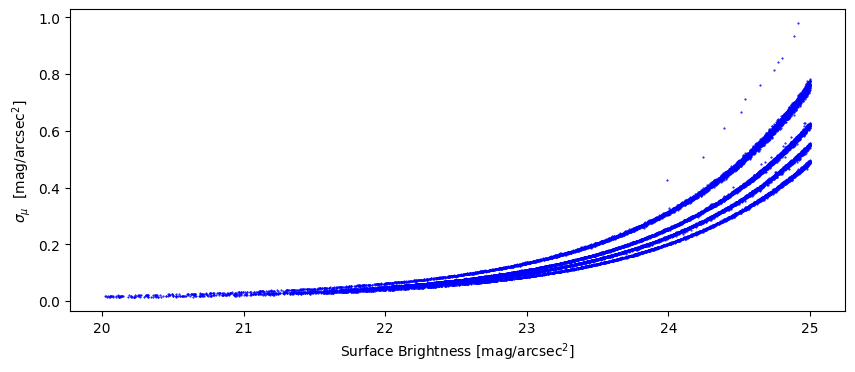

In [14]:
fig, ax = plt.subplots(figsize=(10,4), dpi=100)



err = np.abs(-2.5/np.log(10) * np.sqrt(1/gd.invvar)/flux)
val_m = mag.flatten()
cut = (val_m > 20) & (val_m < 25)
ax.plot(val_m[cut], err.flatten()[cut], 'b.', ms=1)

ax.set_xlabel('Surface Brightness [mag/arcsec$^2]$')
ax.set_ylabel('$\sigma_\mu$  [mag/arcsec$^2$]')
# ax.set_yscale('log')

In [15]:
isophote, width = 22, 0.2
gd.contour_fit(isophote, window=width, mask=True)
ex_out = gd.contours[isophote][1][1]
vals = mag_s.T[ex_out.T[0], ex_out.T[1]]
inv = err.T[ex_out.T[0], ex_out.T[1]]
cuts = (vals>isophote-width) & (vals<isophote+width)
ex_out = ex_out[cuts]
vals = vals[cuts]
inv = inv[cuts]

In [16]:
def lin(x, a, b):return a*x + b
lout = curve_fit(lin, vals, inv)

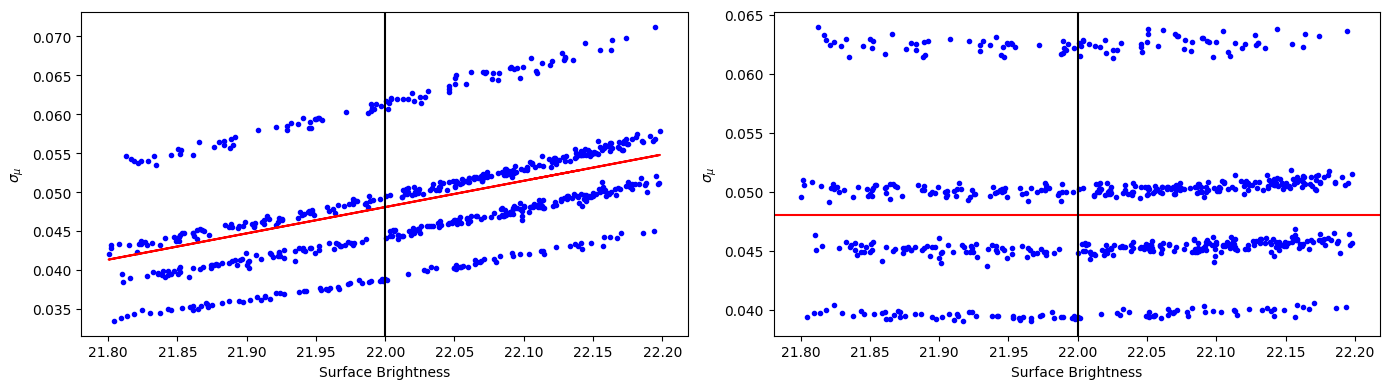

In [17]:
fig, ax = plt.subplots(figsize=(14, 4),dpi=100, ncols=2)
ax[0].plot(vals, inv, 'b.')
ax[0].plot(vals, lin(vals, *lout[0]), 'r-')

# err = (np.abs(vals-isophote))**(1/3) * inv/ lin(vals, *lout[0])
err = inv*inv.mean()/lin(vals, *lout[0])
ax[1].plot(vals, err, 'b.')
ax[1].axhline(lin(isophote, *lout[0]), c='red')
for ax_i in ax:
    ax_i.axvline(isophote, c='black')
    ax_i.set_xlabel('Surface Brightness')
    ax_i.set_ylabel('$\sigma_\mu$')

plt.tight_layout()

In [18]:
df10.columns

<TableColumns names=('brickname','ra','dec','nexp_g','nexp_r','nexp_i','nexp_z','nexphist_g','nexphist_r','nexphist_i','nexphist_z','nobjs','npsf','nsimp','nrex','nexp','ndev','ncomp','nser','ndup','psfsize_g','psfsize_r','psfsize_i','psfsize_z','psfdepth_g','psfdepth_r','psfdepth_i','psfdepth_z','galdepth_g','galdepth_r','galdepth_i','galdepth_z','ebv','trans_g','trans_r','trans_i','trans_z','cosky_g','cosky_r','cosky_i','cosky_z','ext_g','ext_r','ext_i','ext_z','wise_nobs','trans_wise','ext_w1','ext_w2','ext_w3','ext_w4','brickid','ra1','ra2','dec1','dec2','area','survey_primary','in_desi')>

In [19]:
sky_ = df10['cosky_g']
mag_sky = 22.5 + -2.5/np.log(10) * (np.arcsinh(sky_[sky_>0]/(2*0.9e-10*0.262**2)) + np.log(0.9e-10))

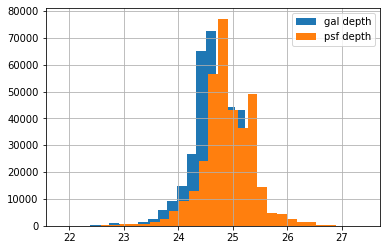

In [20]:
gal_ = df10['galdepth_g']
pd.Series(gal_[gal_ > 0]).hist(bins=30, label='gal depth')

psf_ = df10['psfdepth_g']
pd.Series(psf_[psf_>0]).hist(bins=30, label = 'psf depth')
plt.legend()

Text(0.5, 0, 'sky limit')

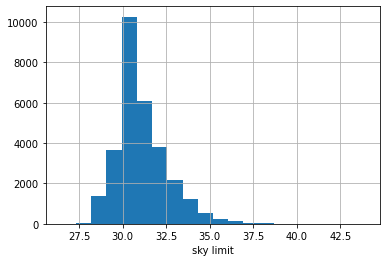

In [21]:
pd.Series(mag_sky).hist(bins=20)
plt.xlabel('sky limit')

<AxesSubplot:>

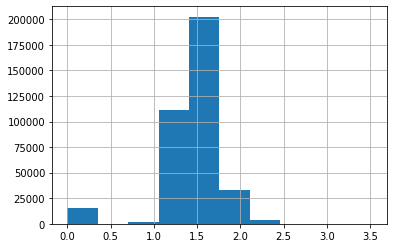

In [22]:
psfsize = df10['psfsize_g']
pd.Series(psfsize).hist(bins=10)

In [56]:
service = 'https://www.legacysurvey.org/viewer/'
url = f'{service}fits-cutout?ra={ra}&dec={dec}&layer=ls-dr10&pixscale=0.262&bands=g&size=300&subimage'
res = requests.get(url, timeout=10)
out = fits.open(BytesIO(res.content))
len(out)

3

In [63]:
c = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
WCS(out[1].header).world_to_pixel(c)

(array(150.01513022), array(149.58521503))

In [58]:
out[1].header

XTENSION= 'IMAGE   '           / IMAGE extension                                
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                  300 / length of data axis 1                          
NAXIS2  =                  300 / length of data axis 2                          
PCOUNT  =                    0 / required keyword; must = 0                     
GCOUNT  =                    1 / required keyword; must = 1                     
SURVEY  = 'LegacySurvey'                                                        
VERSION = 'DR10    '                                                            
IMAGETYP= 'image   '           / None                                           
BRICK   = '0097m105'                                                            
BRICK_X0=                  845                                                  
BRICK_Y0=                 18